In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [3]:
import matplotlib.dates as dates
from scipy import stats
from scipy.stats import variation
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import itertools

In [4]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [5]:
label_fontsize = 16
title_fontsize = 16

In [6]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [7]:
sns.set(font_scale=1.25, style="whitegrid")

In [8]:
%%R
#install.packages("BayesFactor", repos='http://cran.us.r-project.org')

NULL


In [9]:
%%R
rm(list = ls())  #remove elements from current workspace
library("plyr")
library("emmeans")
library("reshape2")
library("multcomp")

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘TH.data’


R[write to console]: The following object is masked from ‘package:MASS’:

    geyser




In [10]:
%%R
basepath = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
behfilepath = "decArsousalDecisionmaking_JNeuroscience2021/beh_data/csv_files/"

In [11]:
%%R
#read the csv file first (created by process_psychophysics)
csvfile = paste(basepath,behfilepath,"psychophysics.csv",sep="")
myoveralldata = read.csv(csvfile) # read csv file

In [12]:
%%R
head(myoveralldata)

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert


In [13]:
%%R
#remove <- c()
subj_idxs = unique(myoveralldata$subj_idx)
#subj_idxs = subj_idxs [! subj_idxs %in% remove]
print(unique(subj_idxs))

#make a dataframe with the same column title as the csv file..
mycopydata3 <- myoveralldata[0,]
mycopydata3 <- cbind(mycopydata3, data.frame(errcnt=double(),stringsAsFactors=FALSE))

 [1]  2  4  5  6  7  9 10 20 21 22 23 24 25 26 27 28 30 31 32 33 34 35 36 37 38
[26] 39 41 42 43 44 45 46


In [14]:
%%R
head(mycopydata3)

[1] subj_idx  stim      leftresp  rightresp totresp   state     errcnt   
<0 rows> (or 0-length row.names)


In [15]:
%%R
#fill in the dataframe with the csv data along with error count..

for (tempidx in 1:length(subj_idxs))
    {
        subjid = subj_idxs[tempidx]
        cat("\nProcessing subject:: ", subjid)
        mydata = myoveralldata[myoveralldata$subj_idx == subjid,]

        #compute error count with copy data..
        mycopydata <- mydata
        mycopydata$errcnt <- NaN
        lefttrials = mycopydata$stim<0
        mycopydata$errcnt[lefttrials] <-mycopydata$rightresp[lefttrials]
        righttrials = mycopydata$stim>0
        mycopydata$errcnt[righttrials] <-mycopydata$leftresp[righttrials]

        mydata$p_right = mydata$rightresp / mydata$totresp
        mydata2 <- mydata[complete.cases(mydata),]

        mycopydata2 <- mycopydata[complete.cases(mydata),]

        mycopydata3 <- rbind(mycopydata3,mycopydata2)

}


Processing subject::  2
Processing subject::  4
Processing subject::  5
Processing subject::  6
Processing subject::  7
Processing subject::  9
Processing subject::  10
Processing subject::  20
Processing subject::  21
Processing subject::  22
Processing subject::  23
Processing subject::  24
Processing subject::  25
Processing subject::  26
Processing subject::  27
Processing subject::  28
Processing subject::  30
Processing subject::  31
Processing subject::  32
Processing subject::  33
Processing subject::  34
Processing subject::  35
Processing subject::  36
Processing subject::  37
Processing subject::  38
Processing subject::  39
Processing subject::  41
Processing subject::  42
Processing subject::  43
Processing subject::  44
Processing subject::  45
Processing subject::  46

In [16]:
%%R
#Add the stimulus code to the dataframe now..

condition1 = c("Alert","Drowsy")
mycopydata3 <- mycopydata3[mycopydata3$state %in% condition1, ]

mycopydata3[which(mycopydata3$stim < 0),"Stim"] <- 'Left'

mycopydata3[which(mycopydata3$stim > 0),"Stim"] <- 'Right'

In [17]:
%%R
print(head(mycopydata3))
print(tail(mycopydata3))

  subj_idx stim leftresp rightresp totresp state errcnt Stim
1        2  -60        2         0       2 Alert      0 Left
2        2  -55        2         0       2 Alert      0 Left
3        2  -50        2         0       2 Alert      0 Left
4        2  -45        4         0       4 Alert      0 Left
5        2  -40        2         0       2 Alert      0 Left
6        2  -35        4         0       4 Alert      0 Left
     subj_idx stim leftresp rightresp totresp  state errcnt  Stim
1595       46   35        0         4       4 Drowsy      0 Right
1596       46   40        0         5       5 Drowsy      0 Right
1597       46   45        0         3       3 Drowsy      0 Right
1598       46   50        0         5       5 Drowsy      0 Right
1599       46   55        0         1       1 Drowsy      0 Right
1600       46   60        0         2       2 Drowsy      0 Right


In [18]:
%%R
#compute the aggregate data of total response, error count grouped on the stimulus code, state and 
#subjectid..

aggstats_df <- aggregate(cbind(totresp, errcnt) ~ (Stim+state+subj_idx), 
                         data=mycopydata3, sum, na.rm=TRUE)

#remove data with total response <=5..
aggstats_df[which(aggstats_df$totresp <= 5),"Stim"] <- NA
aggstats_df <- aggstats_df[complete.cases(aggstats_df),]

#compute proportion of error responses..
aggstats_df$p_err = aggstats_df$errcnt/aggstats_df$totresp

#compute the mean proportion error..
mean_p_err = ddply(aggstats_df, .(Stim,state), summarise, result = mean(p_err))

#compute the standard error of proportion error..
se_p_err = ddply(aggstats_df, .(Stim,state), summarise, result = sd(p_err)/sqrt(length(p_err)))

In [19]:
%%R
#compute the weighted mean and standard error for the above data..
#this is actually not used.. so ignore it..

weighted.var.se <- function(x, w, na.rm=FALSE)
  #  Computes the variance of a weighted mean following Cochran 1977 definition
{
  if (na.rm) { w <- w[i <- !is.na(x)]; x <- x[i] }
  n = length(w)
  xWbar = weighted.mean(x,w,na.rm=na.rm)
  wbar = mean(w)
  out = n/((n-1)*sum(w)^2)*(sum((w*x-wbar*xWbar)^2)-2*xWbar*sum((w-wbar)*(w*x-wbar*xWbar))+
                            xWbar^2*sum((w-wbar)^2))
  return(out)
}

mean_p_err_wtd = ddply(aggstats_df, .(Stim,state), summarise, result = weighted.mean(p_err,totresp))

se_p_err_wtd = ddply(aggstats_df, .(Stim,state), summarise, 
                     result = (sqrt(weighted.var.se(p_err,totresp))))

In [20]:
%%R
#just rounding to the 2 decimal points..
mean_p_err_wtd[,3] <-round(mean_p_err_wtd[,3], digits = 2) 
se_p_err_wtd[,3] <-round(se_p_err_wtd[,3], digits = 2) 

mean_p_err[,3] <-round(mean_p_err[,3], digits = 2) 
se_p_err[,3] <-round(se_p_err[,3], digits = 2) 

mean_p_err

   Stim  state result
1  Left  Alert   0.12
2  Left Drowsy   0.26
3 Right  Alert   0.09
4 Right Drowsy   0.11


In [21]:
%%R
print(head(aggstats_df))
print(tail(aggstats_df))

   Stim  state subj_idx totresp errcnt      p_err
1  Left  Alert        2      56      3 0.05357143
2 Right  Alert        2      55      1 0.01818182
3  Left Drowsy        2     109     26 0.23853211
4 Right Drowsy        2     132      4 0.03030303
5  Left  Alert        4      56      0 0.00000000
6 Right  Alert        4      56     10 0.17857143
     Stim  state subj_idx totresp errcnt      p_err
123  Left Drowsy       45     131     57 0.43511450
124 Right Drowsy       45     152     10 0.06578947
125  Left  Alert       46      55      5 0.09090909
126 Right  Alert       46      56      1 0.01785714
127  Left Drowsy       46      41      9 0.21951220
128 Right Drowsy       46      36      0 0.00000000


In [22]:
%%R
aggstats_df

     Stim  state subj_idx totresp errcnt      p_err
1    Left  Alert        2      56      3 0.05357143
2   Right  Alert        2      55      1 0.01818182
3    Left Drowsy        2     109     26 0.23853211
4   Right Drowsy        2     132      4 0.03030303
5    Left  Alert        4      56      0 0.00000000
6   Right  Alert        4      56     10 0.17857143
7    Left Drowsy        4     252      8 0.03174603
8   Right Drowsy        4     238     49 0.20588235
9    Left  Alert        5      56      2 0.03571429
10  Right  Alert        5      56      4 0.07142857
11   Left Drowsy        5     220     45 0.20454545
12  Right Drowsy        5     235      9 0.03829787
13   Left  Alert        6      55      7 0.12727273
14  Right  Alert        6      54      4 0.07407407
15   Left Drowsy        6     165     22 0.13333333
16  Right Drowsy        6     175     15 0.08571429
17   Left  Alert        7      56      1 0.01785714
18  Right  Alert        7      54      6 0.11111111
19   Left Dr

In [23]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [24]:
%%R
# Step 3: Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

model.null = lmer(p_err ~ 1 + (1|subj_idx), data=aggstats_df,
                  REML=FALSE)

model.state = lmer(p_err ~ state + (1|subj_idx), data=aggstats_df,
                   REML=FALSE)

model.Stim = lmer(p_err ~ Stim + (1|subj_idx), data=aggstats_df,
                  REML=FALSE)

model.StateStim = lmer(p_err ~ state*Stim + (1|subj_idx), data=aggstats_df,
                       REML=FALSE)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [25]:
%%R
#compare the null model, with the state model..
print(anova(model.null,model.state))

Data: aggstats_df
Models:
model.null: p_err ~ 1 + (1 | subj_idx)
model.state: p_err ~ state + (1 | subj_idx)
            Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)   
model.null   3 -116.50 -107.97 61.249  -122.50                            
model.state  4 -125.24 -113.87 66.622  -133.24 10.746      1   0.001045 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
%%R
#compare the null model, with the stim model..
print(anova(model.null,model.Stim))

Data: aggstats_df
Models:
model.null: p_err ~ 1 + (1 | subj_idx)
model.Stim: p_err ~ Stim + (1 | subj_idx)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  3 -116.50 -107.97 61.249  -122.50                             
model.Stim  4 -128.92 -117.54 68.458  -136.92 14.419      1  0.0001463 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [27]:
%%R
#compare the null model, with the statestim model..
print(anova(model.null,model.StateStim))

Data: aggstats_df
Models:
model.null: p_err ~ 1 + (1 | subj_idx)
model.StateStim: p_err ~ state * Stim + (1 | subj_idx)
                Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null       3 -116.50 -107.97 61.249  -122.50                             
model.StateStim  6 -143.96 -126.89 77.980  -155.96 33.462      3  2.573e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
%%R
#the above analysis show that the statestimlevel model has the highest loglikelihood and the next
#highest is the statestim model, now we can make a direct comparison of them both..
print(anova(model.Stim,model.StateStim))

Data: aggstats_df
Models:
model.Stim: p_err ~ Stim + (1 | subj_idx)
model.StateStim: p_err ~ state * Stim + (1 | subj_idx)
                Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.Stim       4 -128.92 -117.54 68.458  -136.92                             
model.StateStim  6 -143.96 -126.89 77.980  -155.96 19.043      2  7.325e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R
#the above analysis show that the statestim model is the most likely model..
#Step4 :let's analyse the same..
print(anova(model.StateStim))

Type III Analysis of Variance Table with Satterthwaite's method
            Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
state      0.21023 0.21023     1 95.07 14.0465 0.0003061 ***
Stim       0.28140 0.28140     1 95.07 18.8018 3.607e-05 ***
state:Stim 0.10312 0.10312     1 95.07  6.8897 0.0101019 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R
#the above table shows that there is a main effect of state(alert, drowsy); stim(left, right); 
#there is an interaction between state, stimulus: means some stimulus are affected by state more than the
#rest, let's find out what..

NULL


In [31]:
%%R
str(aggstats_df)

'data.frame':	127 obs. of  6 variables:
 $ Stim    : chr  "Left" "Right" "Left" "Right" ...
 $ state   : Factor w/ 2 levels "Alert","Drowsy": 1 1 2 2 1 1 2 2 1 1 ...
 $ subj_idx: num  2 2 2 2 4 4 4 4 5 5 ...
 $ totresp : num  56 55 109 132 56 56 252 238 56 56 ...
 $ errcnt  : num  3 1 26 4 0 10 8 49 2 4 ...
 $ p_err   : num  0.0536 0.0182 0.2385 0.0303 0 ...


In [32]:
%%R
# Step 5: Post Hoc comparisions 
aggstats_df$Stimstate <- interaction(aggstats_df$Stim, aggstats_df$state)

model = lmer(p_err ~ Stimstate + (1|subj_idx), data=aggstats_df,
             REML=FALSE)

print(summary(glht(model, mcp(Stimstate="Tukey"))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = p_err ~ Stimstate + (1 | subj_idx), data = aggstats_df, 
    REML = FALSE)

Linear Hypotheses:
                                Estimate Std. Error z value Pr(>|z|)    
Right.Alert - Left.Alert == 0   -0.03718    0.03058  -1.215    0.617    
Left.Drowsy - Left.Alert == 0    0.13844    0.03058   4.526   <1e-04 ***
Right.Drowsy - Left.Alert == 0  -0.01278    0.03086  -0.414    0.976    
Left.Drowsy - Right.Alert == 0   0.17561    0.03058   5.742   <1e-04 ***
Right.Drowsy - Right.Alert == 0  0.02440    0.03086   0.791    0.859    
Right.Drowsy - Left.Drowsy == 0 -0.15122    0.03086  -4.900   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [33]:
%%R
#the above posthoc analysis shows that 
# Left.Drowsy - Left.Alert == 0    *** 
# Right.Drowsy - Right.Alert == 0 

#the righthanders peformance declines on the left side of space when they become drowsy..

NULL


In [34]:
%%R
print(head(aggstats_df))
print(tail(aggstats_df))

   Stim  state subj_idx totresp errcnt      p_err    Stimstate
1  Left  Alert        2      56      3 0.05357143   Left.Alert
2 Right  Alert        2      55      1 0.01818182  Right.Alert
3  Left Drowsy        2     109     26 0.23853211  Left.Drowsy
4 Right Drowsy        2     132      4 0.03030303 Right.Drowsy
5  Left  Alert        4      56      0 0.00000000   Left.Alert
6 Right  Alert        4      56     10 0.17857143  Right.Alert
     Stim  state subj_idx totresp errcnt      p_err    Stimstate
123  Left Drowsy       45     131     57 0.43511450  Left.Drowsy
124 Right Drowsy       45     152     10 0.06578947 Right.Drowsy
125  Left  Alert       46      55      5 0.09090909   Left.Alert
126 Right  Alert       46      56      1 0.01785714  Right.Alert
127  Left Drowsy       46      41      9 0.21951220  Left.Drowsy
128 Right Drowsy       46      36      0 0.00000000 Right.Drowsy


In [35]:
%%R
filename <-file.path(paste(basepath,behfilepath,"error_proportion.csv", sep = ""))
write.csv(aggstats_df, file = filename,row.names=FALSE, na="")

In [36]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [37]:
df_mean_p_err = ro.r('mean_p_err')
with localconverter(ro.default_converter + pandas2ri.converter):
  df_mean_p_err = ro.conversion.rpy2py(df_mean_p_err)
df_mean_p_err

,Stim,state,result
1,Left,Alert,0.12
2,Left,Drowsy,0.26
3,Right,Alert,0.09
4,Right,Drowsy,0.11


In [38]:
df_se_p_err = ro.r('se_p_err')
with localconverter(ro.default_converter + pandas2ri.converter):
  df_se_p_err = ro.conversion.rpy2py(df_se_p_err)
df_se_p_err

,Stim,state,result
1,Left,Alert,0.02
2,Left,Drowsy,0.04
3,Right,Alert,0.01
4,Right,Drowsy,0.02


In [41]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
output_dir = 'decArsousalDecisionmaking_JNeuroscience2021/Figures/'

In [42]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Figures/'

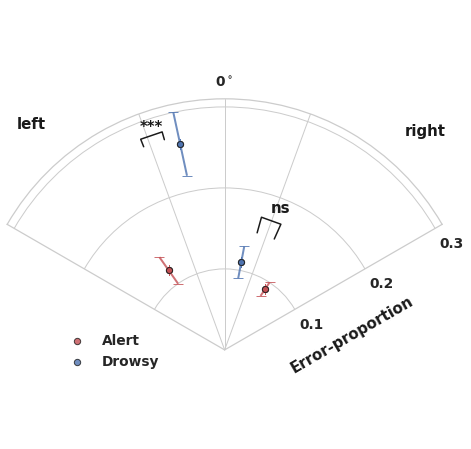

In [45]:
#make the plot summarising the results now..
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 16, endpoint=False))
ax.set_yticks([.1,.2,.3,.4,.5])
ax.set_ylim([0, 0.31])

ax.set_thetamin(30)
ax.set_thetamax(150)


##left alert
radii = df_mean_p_err[df_mean_p_err['Stim'].str.match('Left') & 
                      df_mean_p_err['state'].str.match('Alert')]['result']
error = df_se_p_err[df_se_p_err['Stim'].str.match('Left') &
                    df_se_p_err['state'].str.match('Alert')]['result']
theta = [14.75]

c = ax.scatter(theta, radii, color='r', s=40, alpha = 0.8, edgecolors='k', linewidth=1)
ax.errorbar(theta, radii, yerr=error, xerr=.0,ecolor='r', mfc = 'r', mec = 'k', capsize=5,fmt='o', 
            linewidth=2, alpha = 0.8)


##left drowsy
radii = df_mean_p_err[df_mean_p_err['Stim'].str.match('Left') & 
                      df_mean_p_err['state'].str.match('Drowsy')]['result']
error = df_se_p_err[df_se_p_err['Stim'].str.match('Left') &
                    df_se_p_err['state'].str.match('Drowsy')]['result']
theta = [14.35]
c = ax.scatter(theta, radii, color = 'b', s=40, alpha = 0.8, edgecolors='k', linewidth=1)
ax.errorbar(theta, radii, yerr=error, xerr=.0,ecolor='b', mfc = 'b', mec = 'k',capsize=5,fmt='o',
            linewidth=2, alpha = 0.8)

##right alert
radii = df_mean_p_err[df_mean_p_err['Stim'].str.match('Right') & 
                      df_mean_p_err['state'].str.match('Alert')]['result']
error = df_se_p_err[df_se_p_err['Stim'].str.match('Right') &
                    df_se_p_err['state'].str.match('Alert')]['result']
theta = [13.55]
colors = ['red']
c = ax.scatter(theta, radii, color='r', s=40, alpha = 0.8, edgecolors='k', linewidth=1)
ax.errorbar(theta, radii, yerr=error, xerr=.0,ecolor='r', mfc = 'r', mec = 'k', capsize=5,fmt='o',
            linewidth=2, alpha = 0.8)

##right drowsy
radii = df_mean_p_err[df_mean_p_err['Stim'].str.match('Right') & 
                      df_mean_p_err['state'].str.match('Drowsy')]['result']
error = df_se_p_err[df_se_p_err['Stim'].str.match('Right') &
                    df_se_p_err['state'].str.match('Drowsy')]['result']
theta = [13.95]
c = ax.scatter(theta, radii, color = 'b', s=40, alpha = 0.8, edgecolors='k', linewidth=1)
ax.errorbar(theta, radii, yerr=error, xerr=.0,ecolor='b', mfc = 'b', mec = 'k',capsize=5,fmt='o',
            linewidth=2, alpha = 0.8)

ax.set_xticks([np.deg2rad(70),np.deg2rad(90),np.deg2rad(110)])
ax.axes.xaxis.set_ticklabels(['','0$^\circ$',''], rotation='vertical')

ax.legend(['Alert','Drowsy'],loc='lower left', bbox_to_anchor=(0.10, 0.14), framealpha=0)

# statistical annotation
x1, x2 = 1.30, 1.15 
y,h = 0.15, 0.02
col = 'k' 
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.48, y+h+0.01, "ns", ha='center', va='bottom', color=col)

x1, x2 = 1.95, 1.85  
y,h = 0.27, 0.01
col = 'k' 
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.50, y+h+0.001, "***", ha='center',va='bottom', color=col)

x1, x2 = 2.30, 2.20  
y,h = 0.19, 0.02
ax.text((x1+x2)*.51, y+h+0.15, "left", ha='center',va='bottom', color=col)
ax.text((x1+x2)*.18, y+h+0.15, "right", ha='center',va='bottom', color=col)

ax.text(-.20, 0.16, "Error-proportion", rotation=30, ha='center',va='bottom', color=col)

x1, x2 = 2.30, 2.20  
y,h = 0.19, 0.02
ax.text((x1+x2)*.34, y+h+0.18, "", ha='center',va='bottom', color=col)
plt.box(True)
ax.grid(True)
plt.savefig(fig_dir + "errorproportion.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)